Lets check out the CAMELS data

In [84]:
import os
import h5py
import numpy as np 
import scipy.stats as sp

In [122]:
import corner as DFM
import matplotlib.pyplot as plt

In [2]:
dat_dir = '/Users/chahah/data/uhod/'

In [3]:
fof = h5py.File(os.path.join(dat_dir, 'fof_subhalo_tab_033.hdf5'), 'r')

In [28]:
fof.keys()

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>

In [153]:
pos_h = fof['Group/GroupPos'][...]
pos_cm_h = fof['Group/GroupCM'][...]
vel_h = fof['Group/GroupVel'][...]
logm_h = np.log10(fof['Group/GroupMass'][...]) + 10
radius_h = fof['Group/Group_R_Crit200'][...]
sfr_h = fof['Group/GroupSFR'][...]
metal_h = fof['Group/GroupStarMetallicity'][...]
ngal_h = fof['Group/GroupNsubs'][...]
icen_h = fof['Group/GroupFirstSub'][...]

print('%i halos' % len(logm_h))

18668 halos


In [77]:
has_central = (icen_h >= 0)
print('%i halos have centrals' % np.sum(has_central))

14318 halos have centrals


In [78]:
# Flag field indicating suitability of this subhalo for certain types of analysis. 
# If zero, this subhalo should generally be excluded, and is not thought to be of cosmological origin. 
# If one, this subhalo should be considered a 'galaxy' or 'satellite' 
# flag_g = fof['Subhalo/SubhaloFlag'][...] 
pos_g = fof['Subhalo/SubhaloPos'][...]
vel_g = fof['Subhalo/SubhaloVel'][...]
logm_g = np.log10(fof['Subhalo/SubhaloMassType'][...][:,4]) + 10 # log(stellar mass)

print('%i galaxies' % len(logm_g))

16608 galaxies


/opt/anaconda3/envs/arcoiris/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


In [166]:
vel_g[icen_h[has_central]]

array([[-12.3928   ,  43.362537 ,  44.036636 ],
       [-15.146185 ,  -1.0636744,  18.772871 ],
       [  9.8416195, -47.256256 , -64.17857  ],
       ...,
       [-28.945045 ,  64.977745 , -54.5519   ],
       [-33.535225 ,  51.567093 , -35.627335 ],
       [-46.83329  ,  52.80771  , -36.139412 ]], dtype=float32)

In [168]:
vel_h[has_central]

array([[-13.796748 ,  49.997456 ,  46.01613  ],
       [-22.41566  , -11.0492525,  13.572733 ],
       [ 12.131488 , -45.371853 , -66.11818  ],
       ...,
       [-27.651089 ,  65.355156 , -54.751606 ],
       [-32.64778  ,  51.747738 , -34.847725 ],
       [-45.889336 ,  51.971527 , -37.003986 ]], dtype=float32)

(0.0, 5000.0)

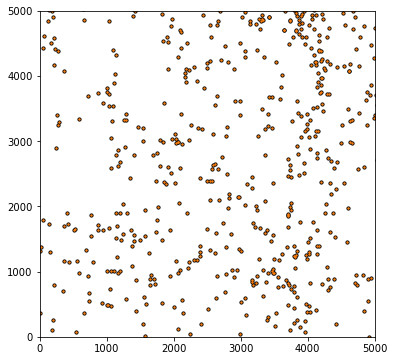

In [70]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(pos_h[has_central,0], pos_h[has_central,1], s=10, c='k')
sub.scatter(pos_g[icen_h[has_central],0], pos_g[icen_h[has_central],1], s=2, c='C1')
sub.set_xlim(0, 5e3)
sub.set_ylim(0, 5e3)

# Lets just focus on central galaxies for now

(0.0, 10000.0)

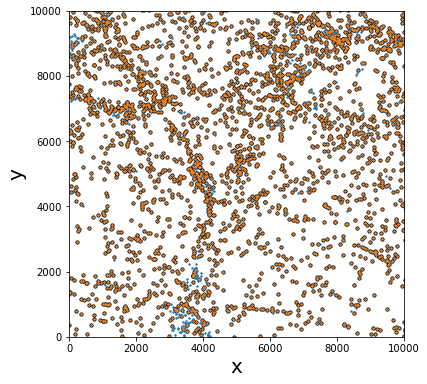

In [81]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(pos_h[has_central,0], pos_h[has_central,1], s=10, c='k') # halo
sub.scatter(pos_g[:,0], pos_g[:,1], s=2, c='C0') # satellites
sub.scatter(pos_g[icen_h[has_central],0], pos_g[icen_h[has_central],1], s=2, c='C1') # centrals
sub.set_xlabel('x', fontsize=20)
sub.set_xlim(0, 1e4)
sub.set_ylabel('y', fontsize=20)
sub.set_ylim(0, 1e4)

In [104]:
ncen_h = np.zeros(len(pos_h))
ncen_h[has_central] = 1.

ncen_logmcut_h = np.zeros(len(pos_h))
ncen_logmcut_h[np.arange(len(pos_h))[has_central][logm_g[icen_h[has_central]] > 9.]] = 1.

In [116]:
ncen_mh, mh_edges, _ = sp.binned_statistic(logm_h, ncen_h, bins=30, range=(8., 14))
ncen_mh_logmcut, _, _ = sp.binned_statistic(logm_h, ncen_logmcut_h, bins=30, range=(8., 14))

Text(0, 0.5, '$<N_{\\rm cen}>$')

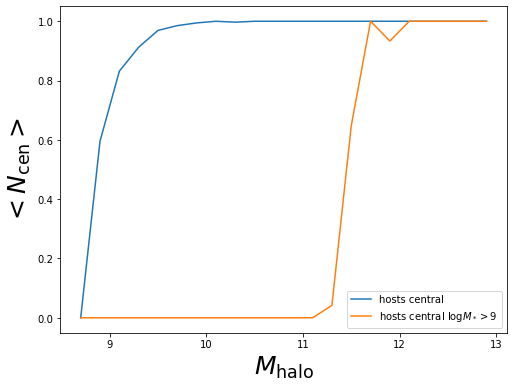

In [119]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.plot(0.5*(mh_edges[:-1] + mh_edges[1:]), ncen_mh, label='hosts central')
sub.plot(0.5*(mh_edges[:-1] + mh_edges[1:]), ncen_mh_logmcut, label=r'hosts central $\log M_* > 9$')
sub.legend(loc='lower right', fontsize=10)
sub.set_xlabel(r'$M_{\rm halo}$', fontsize=25)
sub.set_ylabel(r'$<N_{\rm cen}>$', fontsize=25)

In [142]:
halos_all = np.vstack([logm_h, np.log10(radius_h), np.log10(sfr_h) - logm_h, np.log10(metal_h)]).T
halos_logmcut = halos_all[ncen_logmcut_h.astype(bool)]

/opt/anaconda3/envs/arcoiris/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


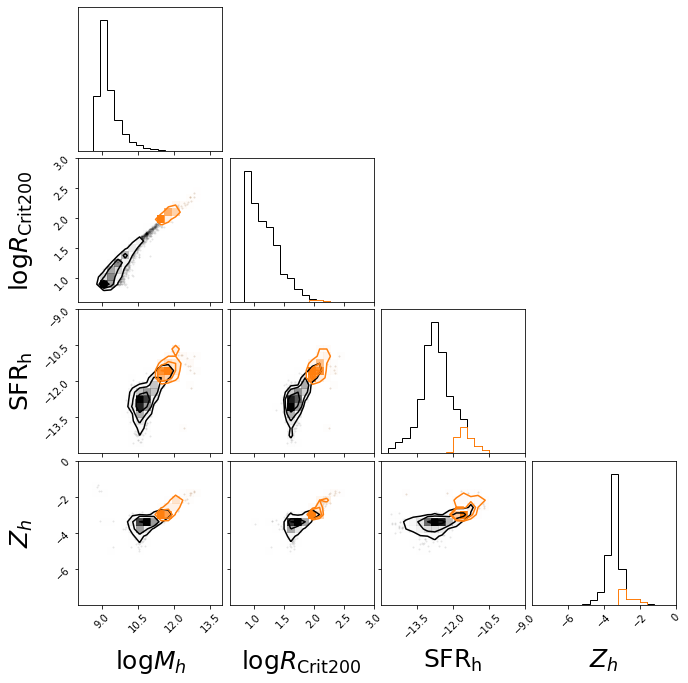

In [149]:
fig = DFM.corner(halos_all, range=[(8., 14.), (0.6, 3), (-15, -9), (-8, 0)])
_ = DFM.corner(halos_logmcut, color='C1',                 
               range=[(8., 14.), (0.6, 3), (-15, -9), (-8, 0)],
               labels=[r'$\log M_h$', r'$\log R_{\rm Crit200}$', r'${\rm SFR_h}$', r'$Z_h$'], 
               label_kwargs={'fontsize': 25}, 
               fig=fig)
#DFM.overplot_points(fig, halos_logmcut, color='C1')

In [157]:
dpos_cen = pos_g[icen_h[has_central]][logm_g[icen_h[has_central]] > 9.] - pos_cm_h[has_central][logm_g[icen_h[has_central]] > 9.]

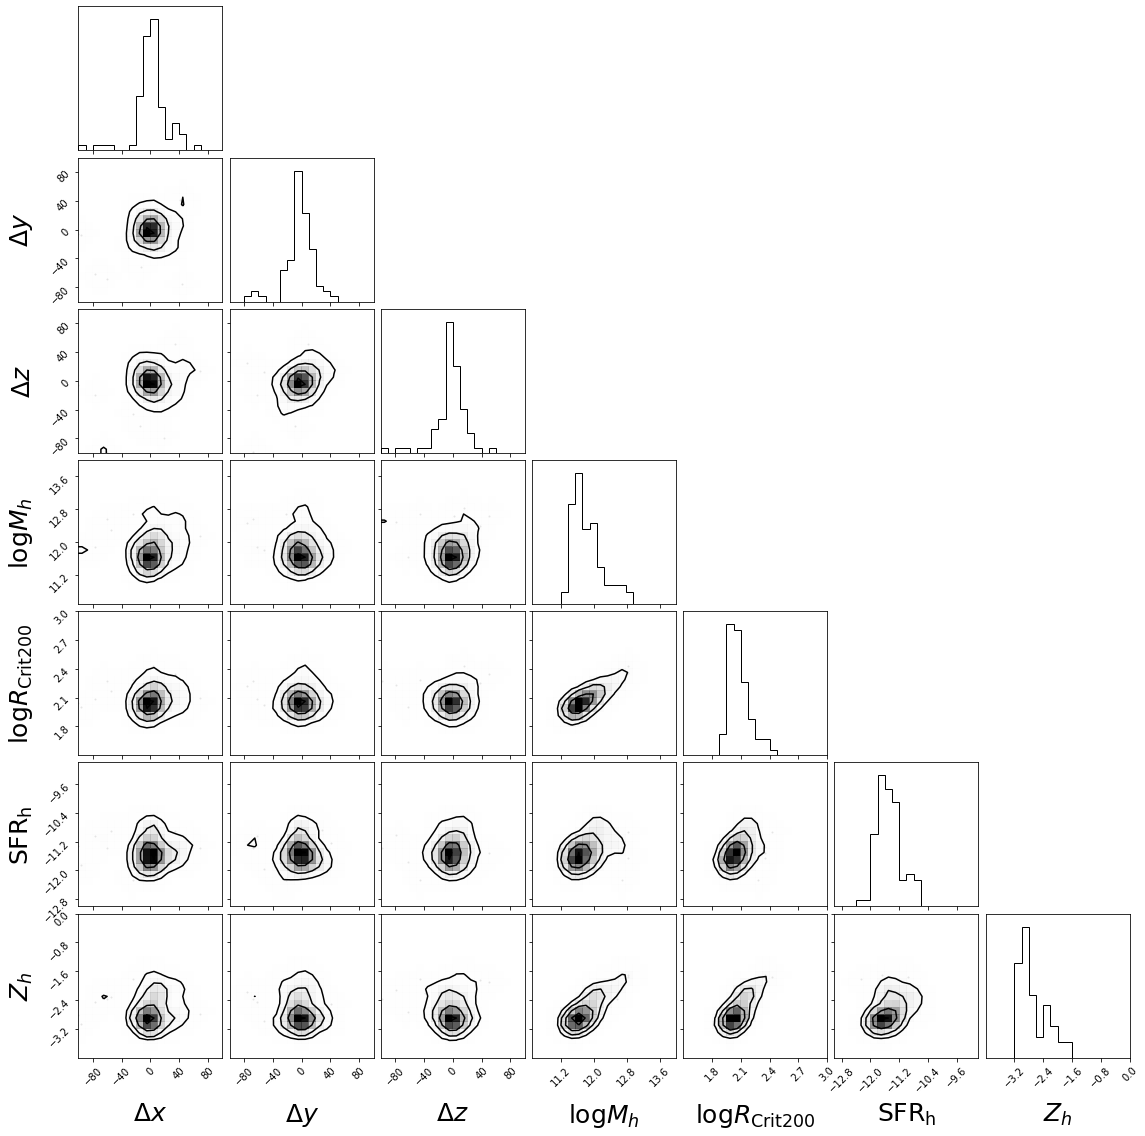

In [172]:
fig = DFM.corner(np.concatenate([dpos_cen, halos_logmcut], axis=1), 
                 range=[(-100, 100), (-100, 100), (-100, 100), (10.5, 14.), (1.5, 3), (-13, -9), (-4, 0)], 
                 labels=[r'$\Delta x$', r'$\Delta y$', r'$\Delta z$', r'$\log M_h$', r'$\log R_{\rm Crit200}$', r'${\rm SFR_h}$', r'$Z_h$'], 
                 label_kwargs={'fontsize': 25}, smooth=True)

In [169]:
dvel_cen = vel_g[icen_h[has_central]][logm_g[icen_h[has_central]] > 9.] - vel_h[has_central][logm_g[icen_h[has_central]] > 9.]

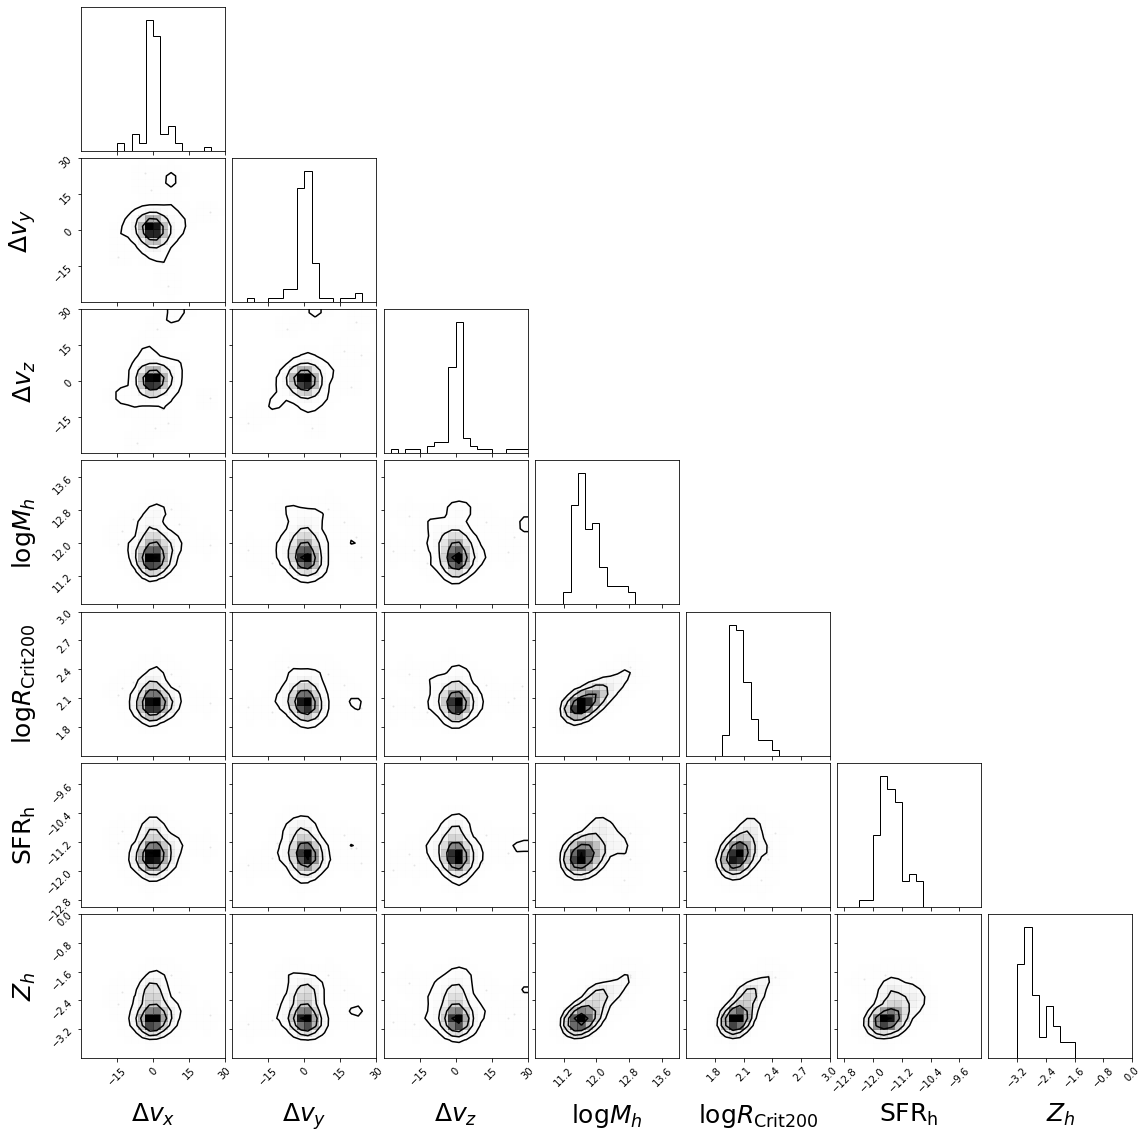

In [173]:
fig = DFM.corner(np.concatenate([dvel_cen, halos_logmcut], axis=1), 
                 range=[(-30, 30), (-30, 30), (-30, 30), (10.5, 14.), (1.5, 3), (-13, -9), (-4, 0)], 
                 labels=[r'$\Delta v_x$', r'$\Delta v_y$', r'$\Delta v_z$', r'$\log M_h$', r'$\log R_{\rm Crit200}$', r'${\rm SFR_h}$', r'$Z_h$'], 
                 label_kwargs={'fontsize': 25}, smooth=True)